In [1]:
import polars as pl
from matplotlib import pyplot as plt
from lets_plot import *
LetsPlot.setup_html()

In [4]:
enso = pl.read_parquet('../data/enso_interpolated.parquet')
data = pl.read_parquet('../data/dataset_complete_dengue_uf.parquet')
# data = data[['date','uf','casos','uf_latitude','uf_longitude','epiweek','week','month','year','rainy']]

data = data.with_columns(
    pl.col("date").dt.date().alias("date")
)

data = data.join(enso, on="date", how="left").sort(['uf','date'])

In [8]:
# (
#     ggplot(data=data)
#     + geom_line(aes(x='date',y='rainy_days'))
#     + facet_grid(y='uf')
# )

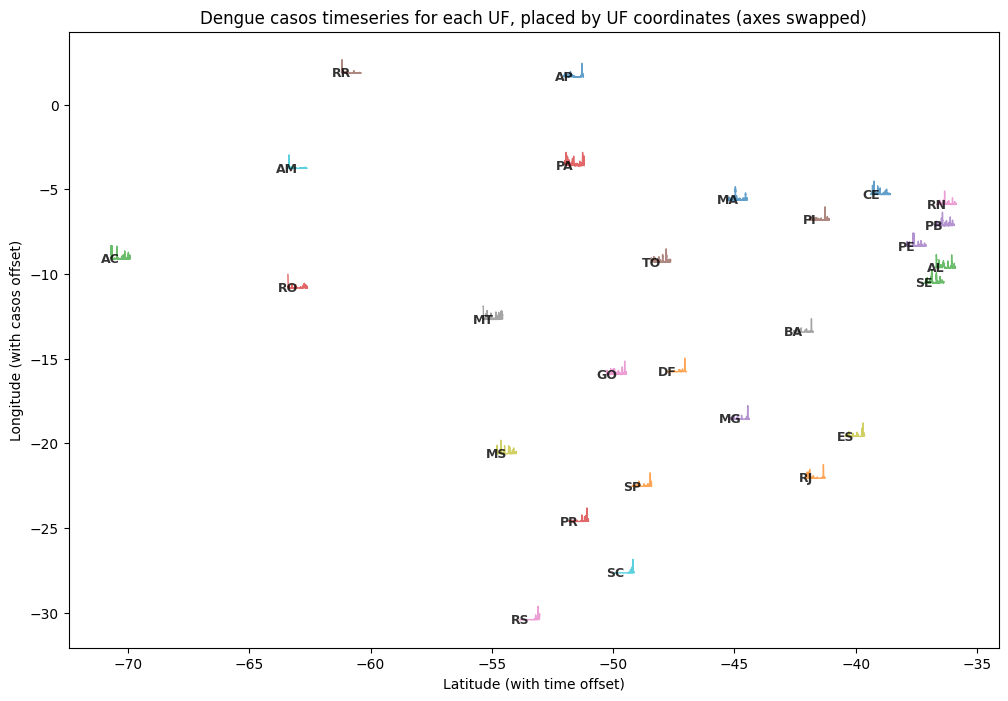

In [50]:
# Plot the timeseries for 'casos' for each 'uf', placing each time-series at its (uf_latitude, uf_longitude)

import numpy as np

# Prepare data for plotting
# We'll plot a small line for each UF at its lat/lon, with time on x and casos on y (offset by lat/lon)
fig, ax = plt.subplots(figsize=(12, 8))

# Get unique UFs and their coordinates
ufs = data.select(['uf', 'uf_latitude', 'uf_longitude']).unique()

for row in ufs.iter_rows(named=True):
    uf = row['uf']
    lat = row['uf_latitude']
    lon = row['uf_longitude']
    # Get time series for this UF
    df_uf = data.filter(pl.col('uf') == uf).sort('date')
    # Normalize time and casos for plotting
    t = np.arange(len(df_uf))
    casos = df_uf['casos'].to_numpy()
    if len(casos) < 2:
        continue
    # Scale time and casos to fit nicely
    t_scaled = (t - t.min()) / (t.max() - t.min() + 1e-9) * .8  # scale to 0-0.8
    casos_scaled = (casos - casos.min()) / (casos.max() - casos.min() + 1e-9) * 0.8  # scale to 0-0.8
    # Offset by lat/lon, but swap axes: latitude is x, longitude is y
    x = lat + t_scaled
    y = lon + casos_scaled
    ax.plot(x, y, lw=1, alpha=0.7)
    # Add UF label at the start of the time series
    ax.text(lat, lon, uf, fontsize=9, ha='center', va='center', fontweight='bold', color='black', alpha=0.8)

ax.set_xlabel('Latitude (with time offset)')
ax.set_ylabel('Longitude (with casos offset)')
ax.set_title('Dengue casos timeseries for each UF, placed by UF coordinates (axes swapped)')
plt.show()